# Estudo sobre a evolução do virus Covid-19 (CORONAVÍRUS)

> [Autor](https://www.linkedin.com/in/alberto-oliveira-barbosa/)

# Fontes dos dados
> [Repositório Johns Hopkins CSSE](https://github.com/CSSEGISandData/COVID-19)  
> [Daily reports](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_daily_reports)  
> [Time Series](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series)


# Avisos

- Os dados das fontes são atualizados no final do dia, por isso dependendo do horário que o notebook for usado, ele pode ou não, conter os dados mais atuais do repositório.  
- Como os dados foram disponibilizados na internet de forma **pública**, o autor não se responsabiliza pela manutenção dos repositórios com os dados nem a exatidão deles com outras fontes, sendo estas, oficiais ou não.  
- Este é um projeto desenvolvido para **fins de estudo**, e tal qual, não tem por objetivo servir de guia ou referência oficial sobre o caso.

# Import de bibliotecas e configurações do notebook

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, accuracy_score

# configuração global dos gráficos
plt.rcParams['figure.figsize'] = (11,6)

# Funções:

In [73]:
# Verifica se a ultima data é válida
# caso o campo de data esteja em branco, ele pega a coluna anterior a ela

def valida_dados(dados, tipo_dataset):
    
    coluna = -1
    data_atualizada = dados.columns[coluna]

    while (dados[data_atualizada].isna().mean() == 1):
        coluna = coluna - 1
        data_atualizada = dados.columns[coluna]

    print('\n', tipo_dataset)
    print('Ultima coluna do dataset: ', dados.columns[-1])
    print('Ultima data com valores válidos: ',data_atualizada)
    return data_atualizada

In [74]:
def plot_total_casos_pais(dados, pais, titulo=None, data_inicial = None, data_final = None):
    dados.groupby('Country/Region').sum().loc[pais][2:][data_inicial:data_final].plot()
    plt.title(titulo, fontsize=18)
    plt.xlabel('Data  (formato: MES/DIA/ANO)')
    plt.ylabel('Total de Casos')
    plt.show()

In [75]:
def plot_novos_casos_pais(dados, pais, titulo=None, data_inicial = None, data_final = None):
    dados.groupby('Country/Region').sum().loc[pais][2:][data_inicial:data_final].diff().plot()
    plt.title(titulo, fontsize=18)
    plt.xlabel('Data  (formato: MES/DIA/ANO)')
    plt.ylabel('Total de Casos')
    plt.show()

---

# Carga e validação dos dados

In [76]:
casos_confirmados = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
mortes_confirmadas = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')


In [77]:
# valida os dados que serão usados nessa analise
data_atual_confirmados = valida_dados(casos_confirmados, 'Dataset de Casos Confirmados')
data_atual_mortes = valida_dados(mortes_confirmadas, 'Dataset de Mortes Confirmadas')
#data_atual_recuperados = valida_dados(casos_recuperados, 'Dataset de Casos Recuperados')


 Dataset de Casos Confirmados
Ultima coluna do dataset:  4/19/20
Ultima data com valores válidos:  4/19/20

 Dataset de Mortes Confirmadas
Ultima coluna do dataset:  4/19/20
Ultima data com valores válidos:  4/19/20


## Dados Sobre Casos Confirmados
### Descrições estatísticas e informações sobre os dados

In [78]:
# primeros registros
casos_confirmados.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,521,555,607,665,714,784,840,906,933,996
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,416,433,446,467,475,494,518,539,548,562
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,1761,1825,1914,1983,2070,2160,2268,2418,2534,2629
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,601,601,638,646,659,673,673,696,704,713
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,19,19,19,19,19,19,19,19,24,24


In [79]:
casos_confirmados.describe()

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,4/10/20,4/11/20,4/12/20,4/13/20,4/14/20,4/15/20,4/16/20,4/17/20,4/18/20,4/19/20
count,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,...,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000,264.000000
mean,21.317326,22.168315,2.102273,2.477273,3.564394,5.431818,8.022727,11.087121,21.128788,23.356061,...,6278.507576,6574.431818,6949.700758,7215.295455,7485.571970,7788.083333,8153.170455,8485.568182,8779.386364,9096.128788
std,24.734994,70.669996,27.382118,27.480921,34.210982,47.612615,66.537101,89.647535,220.011922,221.352587,...,35261.959793,37137.014066,39181.457686,40763.518495,42450.795915,44263.148610,46362.495521,48389.901654,50329.621230,52104.475531
min,-51.796300,-135.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,6.969250,-20.026050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,32.000000,33.750000,33.750000,39.500000,40.750000,48.000000,48.750000,51.250000,55.000000,55.000000
50%,23.488100,20.535638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,256.500000,265.500000,276.000000,294.500000,304.000000,319.000000,331.500000,335.000000,339.000000,341.500000
75%,41.166075,78.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1269.250000,1305.500000,1314.250000,1352.000000,1379.750000,1407.500000,1533.250000,1575.500000,1615.750000,1654.250000
max,71.706900,178.065000,444.000000,444.000000,549.000000,761.000000,1058.000000,1423.000000,3554.000000,3554.000000,...,496535.000000,526396.000000,555313.000000,580619.000000,607670.000000,636350.000000,667592.000000,699706.000000,732197.000000,759086.000000


In [80]:
casos_confirmados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 93 columns):
Province/State    82 non-null object
Country/Region    264 non-null object
Lat               264 non-null float64
Long              264 non-null float64
1/22/20           264 non-null int64
1/23/20           264 non-null int64
1/24/20           264 non-null int64
1/25/20           264 non-null int64
1/26/20           264 non-null int64
1/27/20           264 non-null int64
1/28/20           264 non-null int64
1/29/20           264 non-null int64
1/30/20           264 non-null int64
1/31/20           264 non-null int64
2/1/20            264 non-null int64
2/2/20            264 non-null int64
2/3/20            264 non-null int64
2/4/20            264 non-null int64
2/5/20            264 non-null int64
2/6/20            264 non-null int64
2/7/20            264 non-null int64
2/8/20            264 non-null int64
2/9/20            264 non-null int64
2/10/20           264 non-null int64
2/

In [81]:
casos_confirmados.shape

(264, 93)

In [82]:
# nome das colunas
casos_confirmados.columns

Index(['Province/State', 'Country/Region', 'Lat', 'Long', '1/22/20', '1/23/20',
       '1/24/20', '1/25/20', '1/26/20', '1/27/20', '1/28/20', '1/29/20',
       '1/30/20', '1/31/20', '2/1/20', '2/2/20', '2/3/20', '2/4/20', '2/5/20',
       '2/6/20', '2/7/20', '2/8/20', '2/9/20', '2/10/20', '2/11/20', '2/12/20',
       '2/13/20', '2/14/20', '2/15/20', '2/16/20', '2/17/20', '2/18/20',
       '2/19/20', '2/20/20', '2/21/20', '2/22/20', '2/23/20', '2/24/20',
       '2/25/20', '2/26/20', '2/27/20', '2/28/20', '2/29/20', '3/1/20',
       '3/2/20', '3/3/20', '3/4/20', '3/5/20', '3/6/20', '3/7/20', '3/8/20',
       '3/9/20', '3/10/20', '3/11/20', '3/12/20', '3/13/20', '3/14/20',
       '3/15/20', '3/16/20', '3/17/20', '3/18/20', '3/19/20', '3/20/20',
       '3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20', '3/26/20',
       '3/27/20', '3/28/20', '3/29/20', '3/30/20', '3/31/20', '4/1/20',
       '4/2/20', '4/3/20', '4/4/20', '4/5/20', '4/6/20', '4/7/20', '4/8/20',
       '4/9/20', '4/10/20'

In [83]:
# Verifica a porcentagem de valores faltantes
casos_confirmados.isna().mean() * 100

Province/State    68.939394
Country/Region     0.000000
Lat                0.000000
Long               0.000000
1/22/20            0.000000
                    ...    
4/15/20            0.000000
4/16/20            0.000000
4/17/20            0.000000
4/18/20            0.000000
4/19/20            0.000000
Length: 93, dtype: float64

---

Podemos ver que o dataset é dividido em:  
- Province/State: Dados com a informação da provincia ou estado que foi confirmado o caso.
- Country/Region: País onde foi confirmado o caso.
- Lat: Dados de Latitude.
- Long: Dados de Longitude.
- Colunas com datas: Total Acumulado de casos em cada observação.


Os dados estão dispostos de modo que cada coluna após longitude representa uma data que foi contabilizado o acumulado dos casos.  
Como a coluna que representa os estados está com muito de seus dados faltantes e cada país pode ou não especificar em que região o caso foi confirmado, ela não será considerada para a análise.

## Visualização de Gráficos

## Evolução de total de casos

In [84]:
# paises com casos
print('Total de países com casos confirmados de acordo com o dataset:',casos_confirmados['Country/Region'].nunique())
print('\nLista de países com casos confirmados de acordo com o dataset:\n',casos_confirmados['Country/Region'].unique())

Total de países com casos confirmados de acordo com o dataset: 185

Lista de países com casos confirmados de acordo com o dataset:
 ['Afghanistan' 'Albania' 'Algeria' 'Andorra' 'Angola'
 'Antigua and Barbuda' 'Argentina' 'Armenia' 'Australia' 'Austria'
 'Azerbaijan' 'Bahamas' 'Bahrain' 'Bangladesh' 'Barbados' 'Belarus'
 'Belgium' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina' 'Brazil'
 'Brunei' 'Bulgaria' 'Burkina Faso' 'Cabo Verde' 'Cambodia' 'Cameroon'
 'Canada' 'Central African Republic' 'Chad' 'Chile' 'China' 'Colombia'
 'Congo (Brazzaville)' 'Congo (Kinshasa)' 'Costa Rica' "Cote d'Ivoire"
 'Croatia' 'Diamond Princess' 'Cuba' 'Cyprus' 'Czechia' 'Denmark'
 'Djibouti' 'Dominican Republic' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Eswatini' 'Ethiopia' 'Fiji'
 'Finland' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana' 'Greece'
 'Guatemala' 'Guinea' 'Guyana' 'Haiti' 'Holy See' 'Honduras' 'Hungary'
 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ir

## Top 5 Países com mais casos confirmados

In [85]:
top5 = casos_confirmados.groupby('Country/Region')[data_atual_confirmados].sum().sort_values(ascending=False)[:5].index

print('Total de casos acumulados:\n\n',casos_confirmados.groupby('Country/Region')[data_atual_confirmados].sum().sort_values(ascending=False).head())

Total de casos acumulados:

 Country/Region
US         759086
Spain      198674
Italy      178972
France     154097
Germany    145184
Name: 4/19/20, dtype: int64


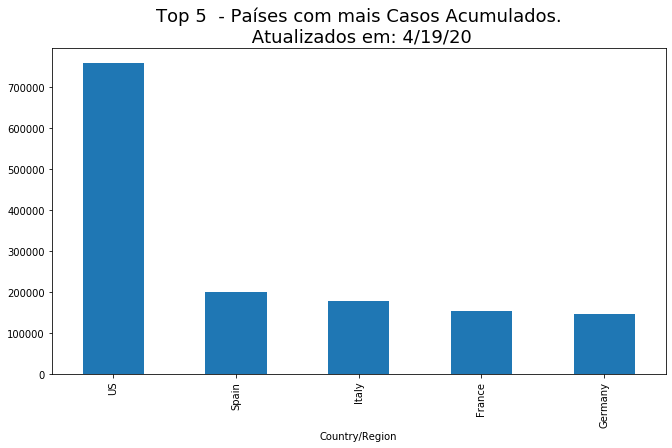

In [86]:
casos_confirmados.groupby('Country/Region')[data_atual_confirmados].sum().sort_values(ascending=False).head().plot(kind='bar')
plt.title(f'Top 5  - Países com mais Casos Acumulados.\n Atualizados em: {data_atual_confirmados}', fontsize=18)
plt.show()

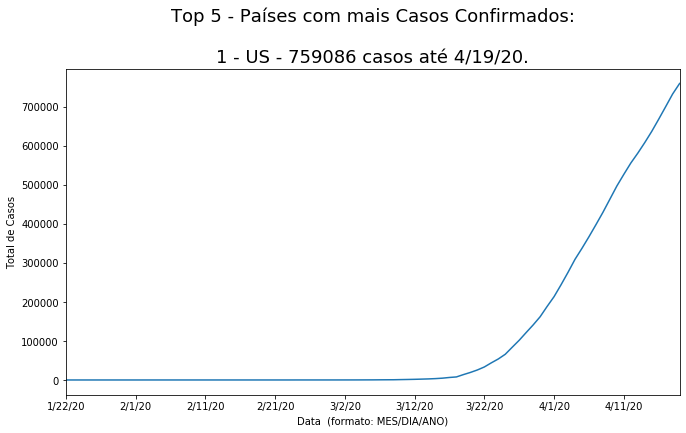

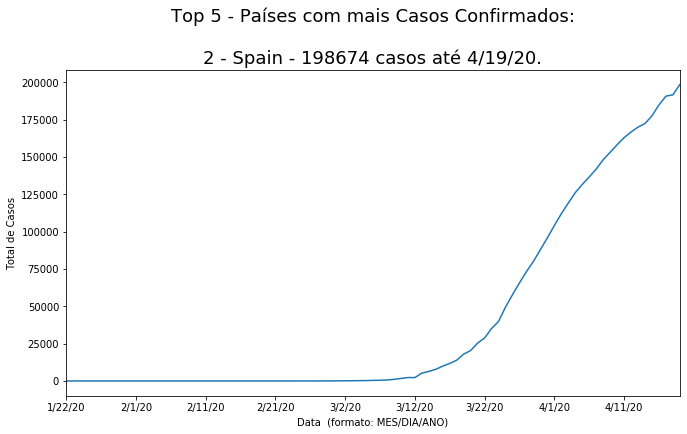

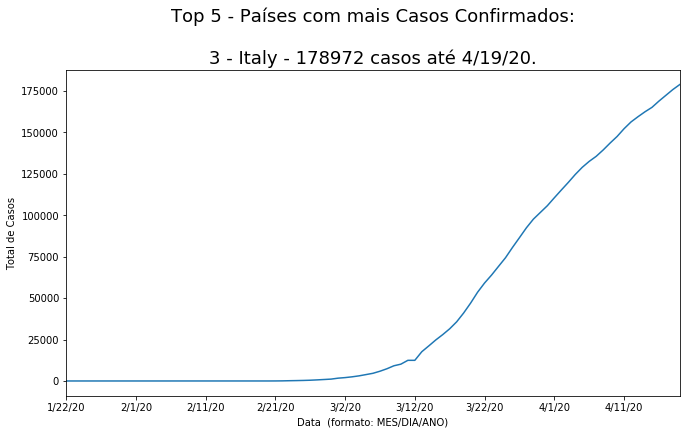

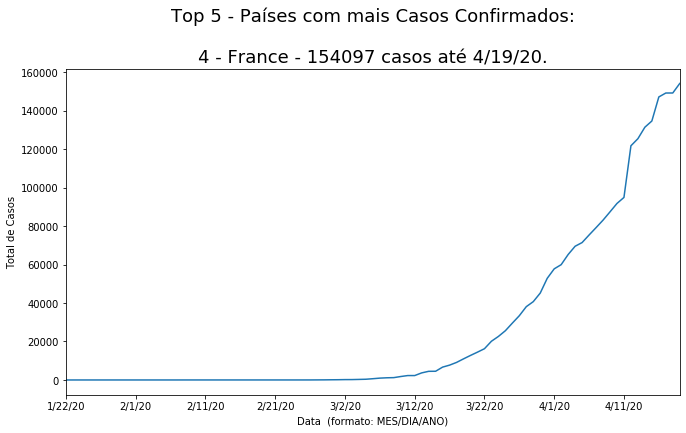

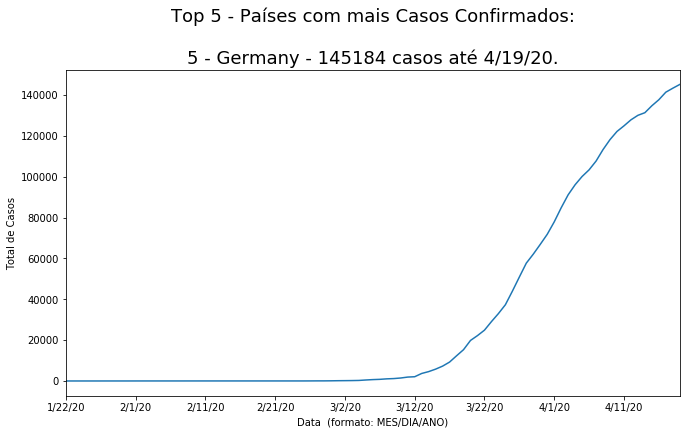

In [87]:
# Plota os graficos de cada país no top 5
for posicao, i in enumerate(top5):
    total = casos_confirmados.groupby('Country/Region')[data_atual_confirmados].sum().loc[i]
    plot_total_casos_pais(casos_confirmados, 
                          i,
                          'Top 5 - Países com mais Casos Confirmados:\n\n' 
                          + str(posicao+1) 
                          + ' - ' + str(i)
                          + ' - ' + str(total) + f' casos até {data_atual_confirmados}.',
                          data_final=data_atual_confirmados)


---


Como essa é uma visualização dos dados acumulados, ela pode não ser tão intuitiva para verificar a real proporção da propagação do virus, por esse motivo a proxima visão será de novos casos confirmados.

## Distribuição dos novos casos ao longo do tempo.

  Como o dataset nos proporciona uma visão acumulada dos dados, a regra utilizada para o calculo será a diferença entre a data posterior e a data anterior observada:
- Data posteriror - Data anterior = Quantidade de casos novos

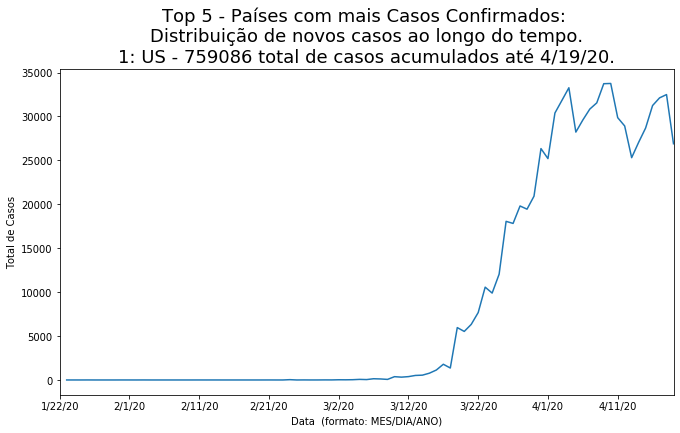

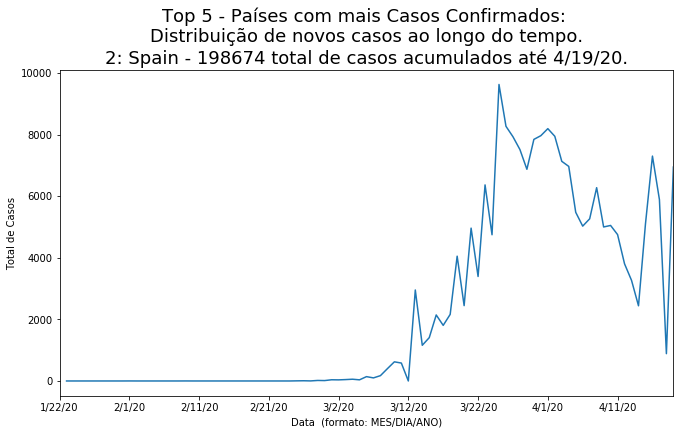

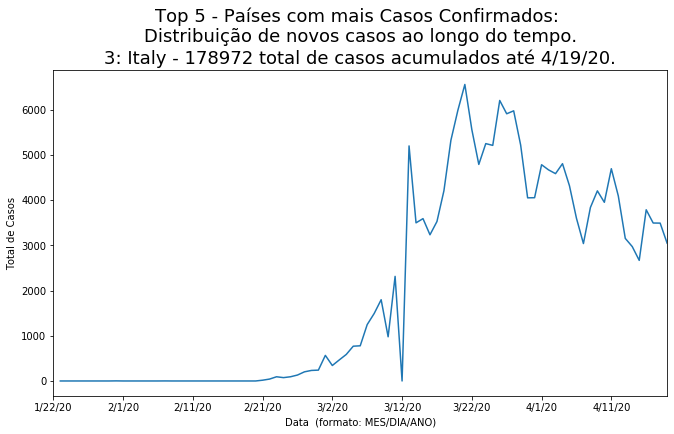

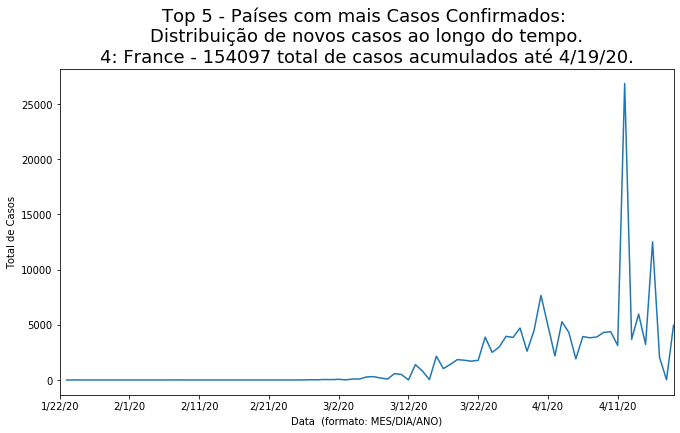

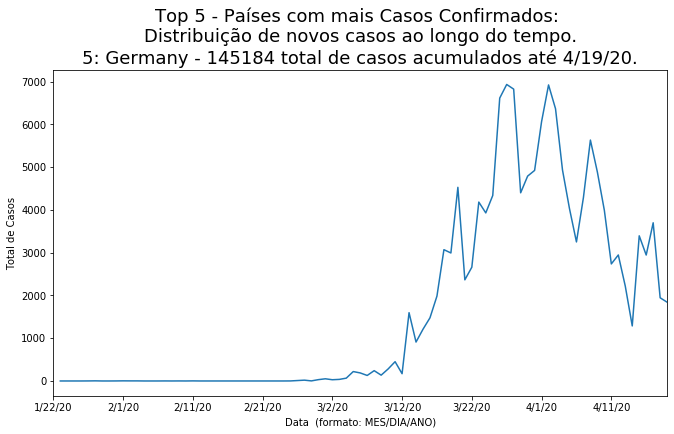

In [88]:
# Plota os graficos de cada país no top 5
for posicao, i in enumerate(top5):
    total = casos_confirmados.groupby('Country/Region')[data_atual_confirmados].sum().loc[i]
    plot_novos_casos_pais(casos_confirmados,
                          i,
                          'Top 5 - Países com mais Casos Confirmados: \nDistribuição de novos casos ao longo do tempo.\n' 
                          + str(posicao+1) 
                          + ': ' + str(i)
                          + ' - ' + str(total) + f' total de casos acumulados até {data_atual_confirmados}.',
                          data_final=data_atual_confirmados)


## Análise das Mortes

## Top 5 - Países com mais casos de mortes

In [89]:
top5_mortes = mortes_confirmadas.groupby('Country/Region')[data_atual_mortes].sum().sort_values(ascending=False)[:5].index

print('Total de mortes acumuladas:\n\n',mortes_confirmadas.groupby('Country/Region')[data_atual_mortes].sum().sort_values(ascending=False).head())

Total de mortes acumuladas:

 Country/Region
US                40661
Italy             23660
Spain             20453
France            19744
United Kingdom    16095
Name: 4/19/20, dtype: int64


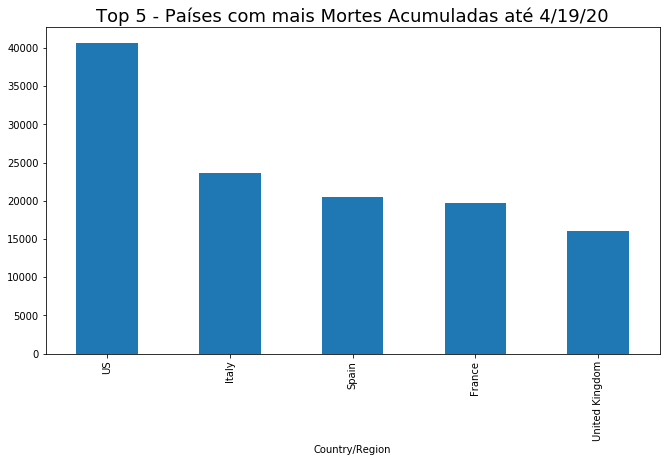

In [90]:
mortes_confirmadas.groupby('Country/Region')[data_atual_mortes].sum().sort_values(ascending=False).head().plot(kind='bar')
plt.title(f'Top 5 - Países com mais Mortes Acumuladas até {data_atual_mortes}', fontsize=18)
plt.show()

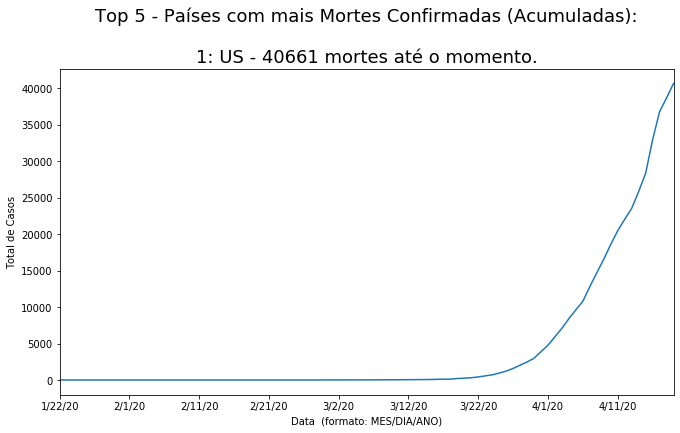

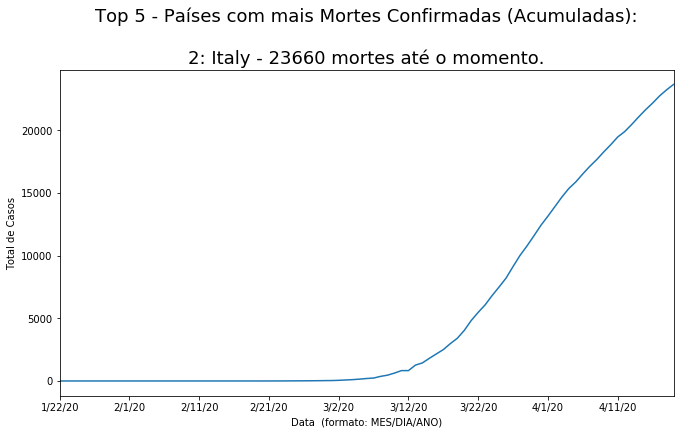

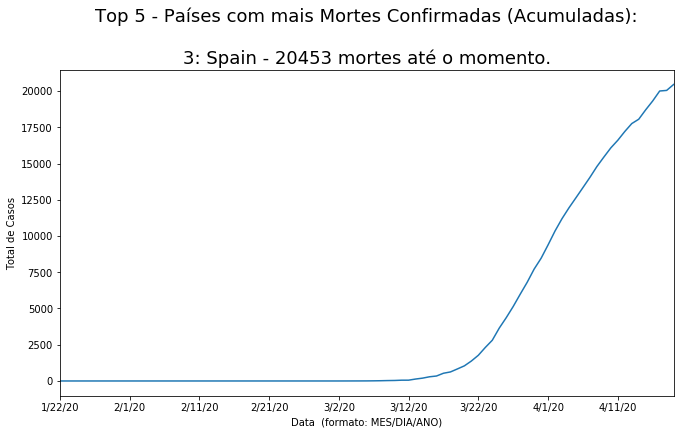

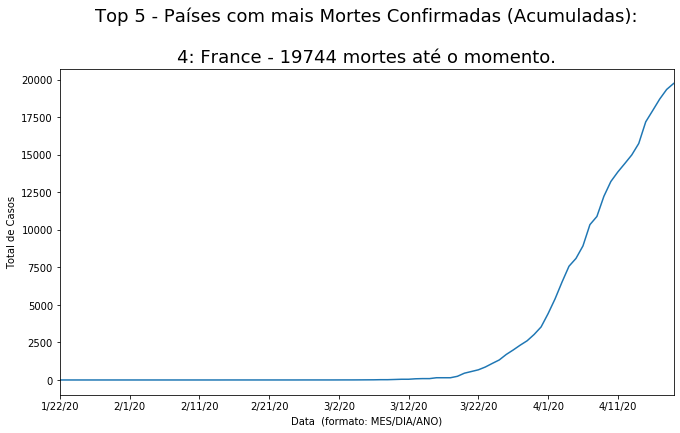

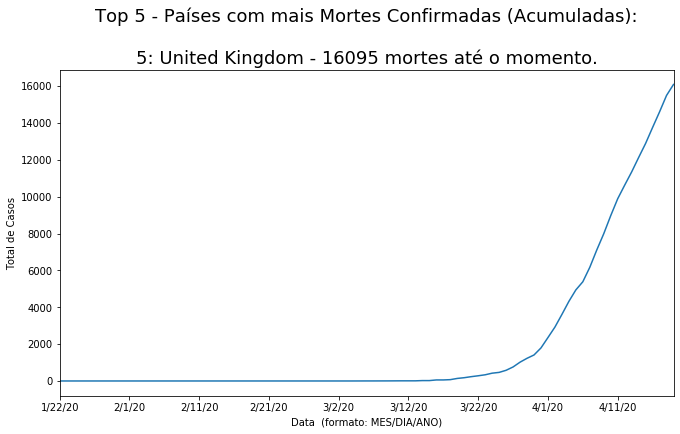

In [91]:
# Plota os graficos de cada país no top 10
for posicao, i in enumerate(top5_mortes):
    total = mortes_confirmadas.groupby('Country/Region')[data_atual_mortes].sum().loc[i]
    plot_total_casos_pais(mortes_confirmadas,
                          i,
                          'Top 5 - Países com mais Mortes Confirmadas (Acumuladas):\n\n' 
                          + str(posicao+1) 
                          + ': ' + str(i)
                          + ' - ' + str(total) + ' mortes até o momento.',
                          data_final=data_atual_confirmados)


## Distribuição das mortes ao longo do tempo.

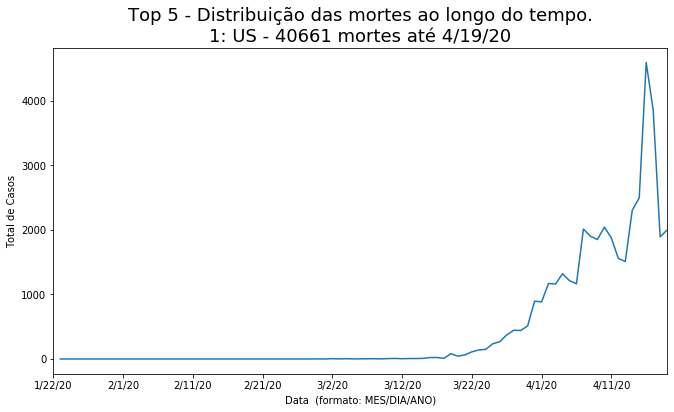

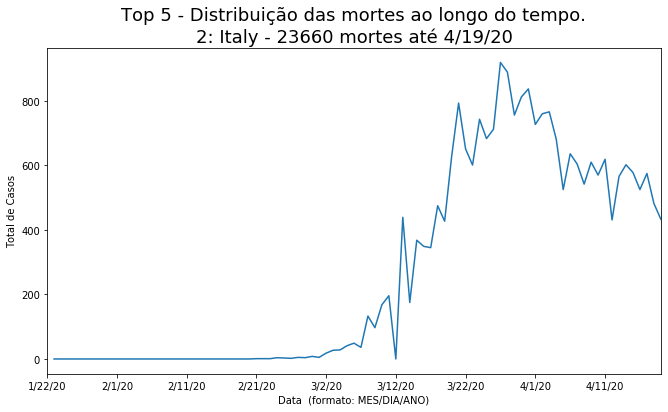

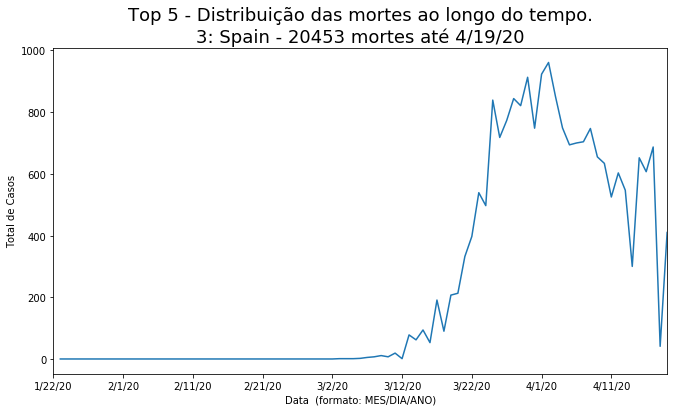

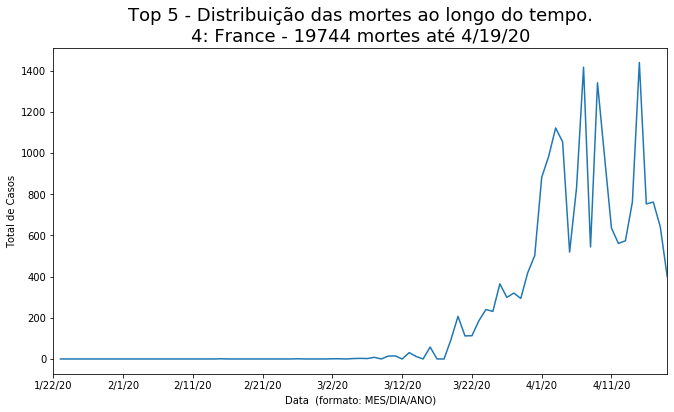

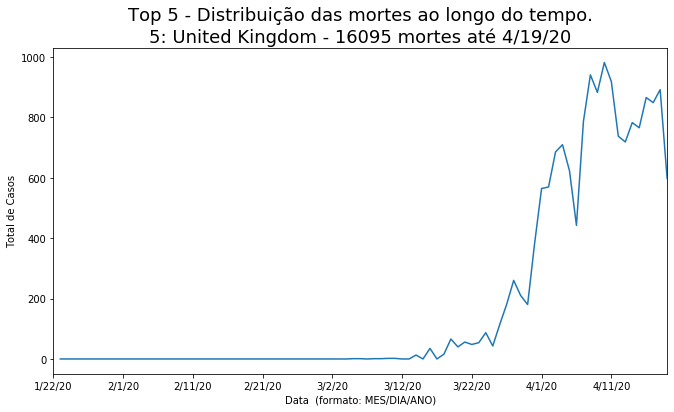

In [92]:
# Plota os graficos de cada país no top 5
for posicao, i in enumerate(top5_mortes):
    total = mortes_confirmadas.groupby('Country/Region')[data_atual_mortes].sum().loc[i]
    plot_novos_casos_pais(mortes_confirmadas,
                          i,
                          'Top 5 - Distribuição das mortes ao longo do tempo.\n' 
                          + str(posicao+1) 
                          + ': ' + str(i)
                          + ' - ' + str(total) + f' mortes até {data_atual_mortes}',
                          data_final=data_atual_mortes)


# Taxa de Letalidade

  Uma das métricas que pode nos dizer sobre o grau de gravidade de uma doença é sua taxa de letalidade, que é a proporção entre o número total de mortes e o total de casos.


**Fórmula:**


***Total de mortes / Total de casos confirmados***


In [93]:
# Cria o dataframe
casos = pd.concat([
    casos_confirmados.groupby('Country/Region').sum().iloc[:,-1],
    mortes_confirmadas.groupby('Country/Region').sum().iloc[:,-1]
], axis=1)

casos.columns = ['confirmados', 'mortes']

casos.head()

,confirmados,mortes
Country/Region,,
Afghanistan,996,33
Albania,562,26
Algeria,2629,375
Andorra,713,36
Angola,24,2


In [94]:
# taxa de letalidade dos paises com mais casos
casos['taxa_letalidade'] = casos['mortes'] / casos['confirmados']  * 100
casos.sort_values('confirmados', ascending=False)[:10]

,confirmados,mortes,taxa_letalidade
Country/Region,,,
US,759086,40661,5.356574
Spain,198674,20453,10.294754
Italy,178972,23660,13.219945
France,154097,19744,12.812709
Germany,145184,4586,3.158750
United Kingdom,121172,16095,13.282772
Turkey,86306,2017,2.337033
China,83805,4636,5.531890
Iran,82211,5118,6.225444


In [95]:
casos.describe()

,confirmados,mortes,taxa_letalidade
count,185.000000,185.000000,185.000000
mean,12980.421622,892.124324,3.959305
std,62054.355915,4214.820028,4.343805
min,1.000000,0.000000,0.000000
25%,61.000000,2.000000,0.817439
50%,579.000000,9.000000,2.723735
75%,3792.000000,97.000000,5.156643
max,759086.000000,40661.000000,22.222222


  Com o resumo estatístico dos dados podemos ver alguns pontos sobre a distribuição dos dados, como a diferença dos primeiros colocados no rank de mais casos, o que pode influênciar ou dificultar as análises dos casos.


  Para evitar o impacto disso e facilitar as visualizações, os dados serão divididos usando como referência seu 3° Quartil (valor que divide os dados em 2 grupos: 75% abaixo dele e 25% acima)

In [96]:
acima_q3 = casos[casos['confirmados'] > casos['confirmados'].quantile(0.75)]
q3 = casos[casos['confirmados'] <= casos['confirmados'].quantile(0.75)]
print('Quantidade de países no grupo acima do Terceiro Quartil:',acima_q3.shape[0],'\n Lista dos países:\n', list(acima_q3.index))
print('\nQuantidade de países incluidos no grupo do Terceiro Quartil:',q3.shape[0], '\n Lista dos países:\n', list(q3.index))

Quantidade de países no grupo acima do Terceiro Quartil: 46 
 Lista dos países:
 ['Australia', 'Austria', 'Belarus', 'Belgium', 'Brazil', 'Canada', 'Chile', 'China', 'Czechia', 'Denmark', 'Dominican Republic', 'Ecuador', 'France', 'Germany', 'India', 'Indonesia', 'Iran', 'Ireland', 'Israel', 'Italy', 'Japan', 'Korea, South', 'Malaysia', 'Mexico', 'Netherlands', 'Norway', 'Pakistan', 'Panama', 'Peru', 'Philippines', 'Poland', 'Portugal', 'Qatar', 'Romania', 'Russia', 'Saudi Arabia', 'Serbia', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'Turkey', 'US', 'Ukraine', 'United Arab Emirates', 'United Kingdom']

Quantidade de países incluidos no grupo do Terceiro Quartil: 139 
 Lista dos países:
 ['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Burund

Text(0.5, 1.0, 'Grupo com mais casos Relatados.')

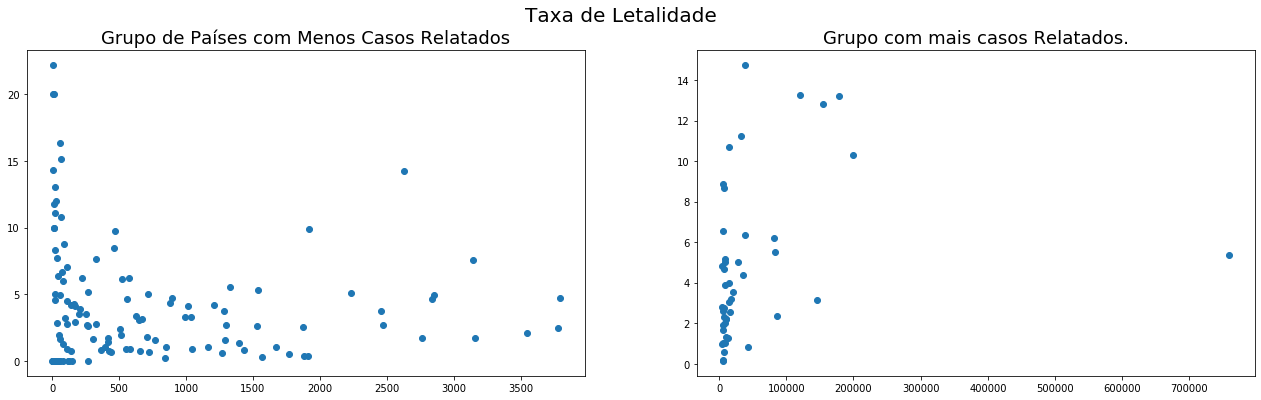

In [97]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,6))
fig.suptitle('Taxa de Letalidade', fontsize=20)
ax1.scatter(x='confirmados', y='taxa_letalidade', data=q3)
ax1.set_title('Grupo de Países com Menos Casos Relatados', fontsize=18)
ax2.scatter(x='confirmados', y='taxa_letalidade', data=acima_q3)
ax2.set_title('Grupo com mais casos Relatados.', fontsize=18)

# E o Brasil?

In [98]:
ultimos_15_dias = pd.to_datetime(data_atual_confirmados) 
ultimos_15_dias = ultimos_15_dias - datetime.timedelta(days=15)
ultimos_15_dias = str(ultimos_15_dias.month) + '/' + str(ultimos_15_dias.day) + '/' + str(ultimos_15_dias.strftime('%y'))
print('Situação do Brasil:')
print(casos.loc['Brazil'].round(2))

Situação do Brasil:
confirmados        38654.00
mortes              2462.00
taxa_letalidade        6.37
Name: Brazil, dtype: float64


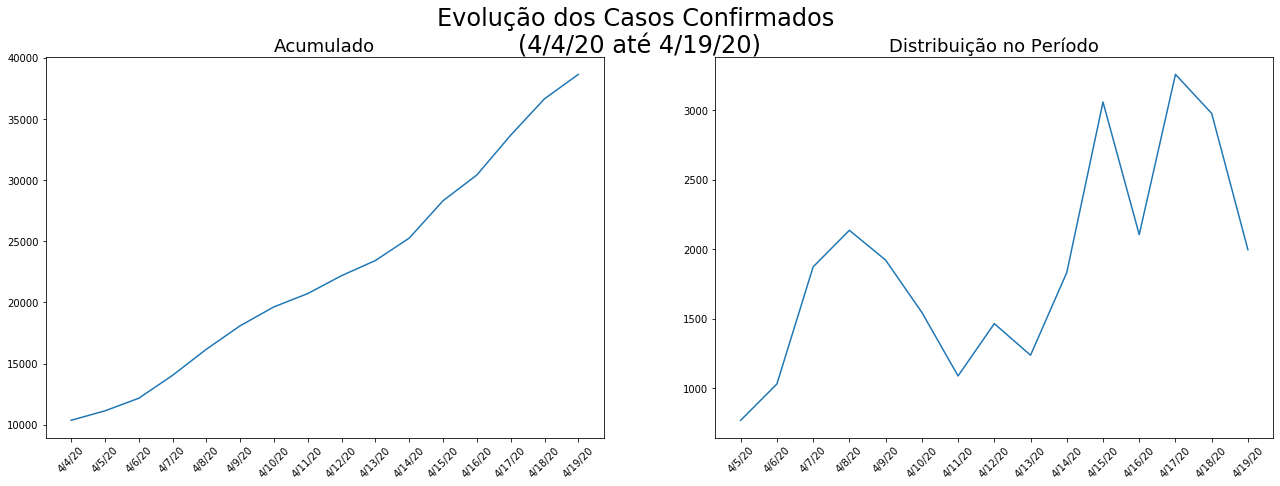

In [99]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,7))
fig.suptitle(f'Evolução dos Casos Confirmados \n({ultimos_15_dias} até {data_atual_confirmados})', fontsize=24)
ax1.plot(casos_confirmados.groupby('Country/Region').sum().loc['Brazil'][2:][ultimos_15_dias:])
ax1.set_title('Acumulado', fontsize=18)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.plot(casos_confirmados.groupby('Country/Region').sum().loc['Brazil'][2:][ultimos_15_dias:].diff())
ax2.set_title('Distribuição no Período', fontsize=18)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.show()

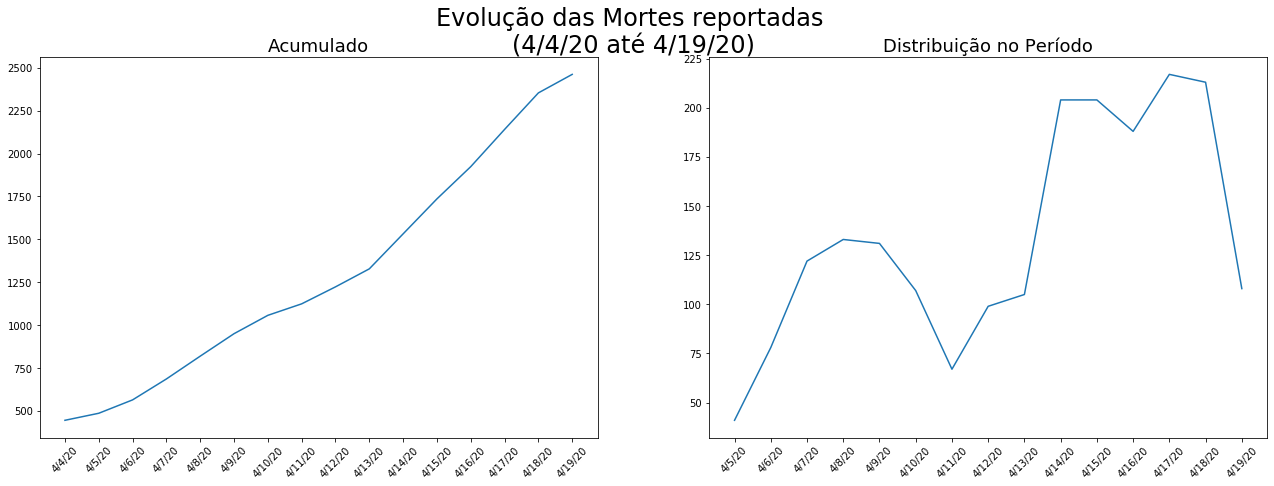

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22,7))
fig.suptitle(f'Evolução das Mortes reportadas \n({ultimos_15_dias} até {data_atual_confirmados})', fontsize=24)
ax1.plot(mortes_confirmadas.groupby('Country/Region').sum().loc['Brazil'][2:][ultimos_15_dias:])
ax1.set_title('Acumulado', fontsize=18)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
ax2.plot(mortes_confirmadas.groupby('Country/Region').sum().loc['Brazil'][2:][ultimos_15_dias:].diff())
ax2.set_title('Distribuição no Período', fontsize=18)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45)
plt.show()

# Tabela com os dados dos 10 países com mais casos confirmados

In [101]:
print('Top 10 - Países com mais Casos confirmados')
display(casos.sort_values('confirmados', ascending=False).head(15))

Top 10 - Países com mais Casos confirmados


,confirmados,mortes,taxa_letalidade
Country/Region,,,
US,759086,40661,5.356574
Spain,198674,20453,10.294754
Italy,178972,23660,13.219945
France,154097,19744,12.812709
Germany,145184,4586,3.158750
United Kingdom,121172,16095,13.282772
Turkey,86306,2017,2.337033
China,83805,4636,5.531890
Iran,82211,5118,6.225444


# Tabela com os dados dos 10 países com mais mortes confirmadas

In [102]:
print('Top 10 - Países com mais mortes confirmadas')
casos.sort_values('mortes', ascending=False).head(10)

Top 10 - Países com mais mortes confirmadas


,confirmados,mortes,taxa_letalidade
Country/Region,,,
US,759086,40661,5.356574
Italy,178972,23660,13.219945
Spain,198674,20453,10.294754
France,154097,19744,12.812709
United Kingdom,121172,16095,13.282772
Belgium,38496,5683,14.762573
Iran,82211,5118,6.225444
China,83805,4636,5.531890
Germany,145184,4586,3.158750


# Total de Casos (Geral/Mundo)

In [103]:
print('Total de casos confirmados no mundo: ', int(casos.sum()[0]))

Total de casos confirmados no mundo:  2401378


# Total de Mortes (Geral/Mundo)

In [104]:
print('Total de mortes no mundo: ', int(casos.sum()[1]))

Total de mortes no mundo:  165043


# Taxa de letalidade mundial

In [105]:
print('Taxa de letalidade dos casos relatados no mundo: ',round(casos.sum()[1]/casos.sum()[0] * 100,2), '%')

Taxa de letalidade dos casos relatados no mundo:  6.87 %
